In [1]:
import sys
import os

# Append the directory of clean_cresci_2015.py to sys.path
sys.path.append(os.path.abspath("../Code"))

from import_data import ImportData
from evaluation import Evaluate 
from feature_selection import FeatureSelection

Import Data

In [2]:
importer = ImportData()
data = importer.read_and_sample_data(bot_ratio=[.4, .6])

Feature Selection

In [3]:
selection = FeatureSelection(data)
_, features = selection.correlation()
features

['friends_count',
 'followers_to_friends_ratio',
 'followers_count',
 'account_age_years',
 'reply_ration',
 'statuses_count',
 'num_mentions',
 'num_urls',
 'listed_count',
 'favorite_count',
 'reply_count',
 'retweet_ratio',
 'retweet_count',
 'num_hashtags',
 'favourites_count',
 'num_tweets']

Splits

In [4]:
splits = importer.split_dataset(data)

## Creating a file for model parameters 

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Define and initialize models with parameters
logistic_model = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs', penalty='l2')
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')
tree_model = DecisionTreeClassifier(max_depth=None, criterion='gini')
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

# # Save the models
# joblib.dump(logistic_model, '../Parameters/logistic_regression.pkl')
# joblib.dump(svm_model, '../Parameters/svm.pkl')
# joblib.dump(tree_model, '../Parameters/decision_tree.pkl')
# joblib.dump(knn_model, '../Parameters/knn.pkl')


['../Parameters/knn.pkl']

## Building a Testing Class

In [14]:
import os
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

class ModelTester:
    def __init__(self, data_dict, feature_importance):
        self.X_train = data_dict['X_train']
        self.X_test = data_dict['X_test']
        self.X_val = data_dict['X_val']
        self.y_train = data_dict['y_train']
        self.y_test = data_dict['y_test']
        self.y_val = data_dict['y_val']
        self.feature_importance = feature_importance
        self.models = {}  # Dictionary to store models and their parameters
        
        # Initialize models with parameters from 'Parameters' folder
        self.load_models()

        # Createa a template parametre GRID for initial test of each model
        logistic_regression_params = {
            'penalty': ['l2', 'none'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 500],
            'multi_class': ['auto', 'ovr', 'multinomial'],
            'class_weight': [None, 'balanced']
        }

        knn_params = {
            'n_neighbors': [3, 5, 7, 10, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 50],
            'p': [1, 2]
        }

        svm_params = {
            'C': [0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4],
            'coef0': [0.0, 0.1, 0.5, 1.0],
            'shrinking': [True, False],
            'probability': [True, False],
            'class_weight': [None, 'balanced']
        }

        decision_tree_params = {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 20, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2', None],
            'class_weight': [None, 'balanced']
        }

        # Combine all parameter grids into a dictionary
        self.parameters_dict = {
            'logistic_regression': logistic_regression_params,
            'knn': knn_params,
            'svm': svm_params,
            'decision_tree': decision_tree_params
        }


    def load_models(self):
        """
        Load models with parameters from 'Parameters' folder.
        """
        parameters_folder = '../Parameters'
        for filename in os.listdir(parameters_folder):
            if filename.endswith('.pkl'):
                model_name = filename.split('.')[0]
                model = joblib.load(os.path.join(parameters_folder, filename))
                self.models[model_name] = model

    def change_model_parameters(self, model_name, new_params):
        """
        Change parameters of the specified model.
        
        Args:
        - model_name: Name of the model to change parameters for.
        - new_params: Dictionary containing new parameter values.
        """
        model = self.models[model_name]
        model.set_params(**new_params)
        self.models[model_name] = model

    def save_current_parameters(self, model_name):
        """
        Save the current parameters of the specified model to 'Parameters' folder.
        
        Args:
        - model_name: Name of the model to save parameters for.
        """
        parameters_folder = '../Parameters'
        joblib.dump(self.models[model_name], os.path.join(parameters_folder, f"{model_name}.pkl"))

    def grid_search(self, model_name, param_grid=None, scoring='f1', num_features=None, save_feature=False):
        """
        Perform grid search to fine-tune parameters for the specified model.
        
        Args:
        - model_name: Name of the model to perform grid search on.
        - param_grid: Dictionary specifying the range of parameters for grid search (default is None, which uses self.parameters_dict).
        - scoring: Scoring metric for grid search optimization (default is 'f1').
        - num_features: Number of features to consider in the grid search (default is None, which uses all features).
        """
        if param_grid is None:
            param_grid = self.parameters_dict[model_name]
            
        model = self.models[model_name]
        grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)

        # Search according to the specified number of features 
        if num_features is None:
            grid_search.fit(self.X_train, self.y_train)
        else:
            # Check if the number of features is valid
            if num_features <= 0 or num_features > len(self.X_train.columns):
                raise ValueError("Invalid number of features provided.")
            
            # Fit the model using the specified number of features
            grid_search.fit(self.X_train.iloc[:, :num_features], self.y_train)

        best_params = grid_search.best_params_
        self.change_model_parameters(model_name, best_params)

        # Save the result if true
        if save_feature:
            self.save_current_parameters(model_name)

        return best_params
    
    def fit_all_models(self):
        """
        Fit all models with the training data.
        """
        for model_name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
            self.models[model_name] = model

    def predict_model(self, model_name):
        """
        Generate predictions (class labels and probabilities) for the chosen model using test and validation data.
        
        Args:
        - model_name: Name of the model for which predictions are generated.
        
        Returns:
        - predictions_dict: Dictionary containing predicted class labels and probabilities for test and validation data.
                            Keys: 'test_predictions', 'test_probabilities', 'val_predictions', 'val_probabilities'
        """
        if model_name not in self.models:
            raise ValueError("Model not found in the dictionary.")
        
        model = self.models[model_name]
        
        # Predictions and probabilities on test data
        test_predictions = model.predict(self.X_test)
        test_probabilities = model.predict_proba(self.X_test)[:, 1]  # Extract probabilities of positive class (class 1)
        
        # Predictions and probabilities on validation data
        val_predictions = model.predict(self.X_val)
        val_probabilities = model.predict_proba(self.X_val)[:, 1]
        
        # Construct the predictions dictionary
        predictions_dict = {
            'test_predictions': test_predictions,
            'test_probabilities': test_probabilities,
            'val_predictions': val_predictions,
            'val_probabilities': val_probabilities
        }
        
        return predictions_dict

In [15]:
tester = ModelTester(splits, features)

See the models

In [7]:
tester.models

{'decision_tree': DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                        splitter='random'),
 'knn': KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1),
 'logistic_regression': LogisticRegression(C=0.001, max_iter=50, solver='newton-cg'),
 'svm': SVC(C=1000, class_weight='balanced', coef0=0.1, degree=2, kernel='poly',
     probability=True)}

Look at the parametres 

In [134]:
tester.models['decision_tree'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}

Change a parametre

In [104]:
tester.change_model_parameters('decision_tree', {
    'criterion': 'manhattan',
    'max_depth': 2,
})
tester.models['decision_tree'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'manhattan',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Save Parametres 

In [37]:
tester.save_current_parameters('decision_tree')

In [110]:
#tester.load_models()
tester.models['logistic_regression'].get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Grid Search

In [131]:
for model in tester.models.keys():
    best_params = tester.grid_search(model, save_feature=True)
    print(f"{model}\n{best_params}\n\n")

decision_tree
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}




c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

knn
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}




c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\jmanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

logistic_regression
{'C': 0.001, 'class_weight': None, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}


svm
{'C': 1000, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'shrinking': True}




In [118]:
# Perform grid search for the selected model
param_grid = {'C': [0.1, 1, 10]}
best_params = tester.grid_search('svm')

Fit Models

In [16]:
tester.fit_all_models()

In [17]:
svm_predictions = tester.predict_model('svm')

Evaluation

In [10]:
splits.keys()

dict_keys(['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val'])

In [18]:
test_evaluation = Evaluate(true_values=splits['y_test'], 
                           predicted_values=svm_predictions['test_predictions'], 
                           predicted_probabilities=svm_predictions['test_probabilities']
                           )

In [19]:
test_evaluation.get_all_metrics()

{'Accuracy': 0.9885057471264368,
 'TN Rate': 0.40229885057471265,
 'FP Rate': 0.0,
 'FN Rate': 0.011494252873563218,
 'TP Rate': 0.5862068965517241,
 'Precision': 1.0,
 'Recall': 0.9807692307692307,
 'F1 Score': 0.9902912621359222,
 'MCC': 0.9764863752380988,
 'AUC': 0.9818681318681318}

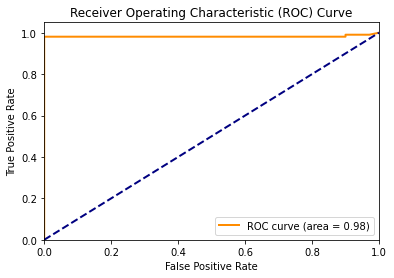

In [22]:
test_evaluation.plot_roc_curve()